# 图像数据加载与增强

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/tutorials/zh_cn/advanced/dataset/mindspore_augment_image_data.ipynb)&emsp;
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/tutorials/zh_cn/advanced/dataset/mindspore_augment_image_data.py)&emsp;
[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/tutorials/source_zh_cn/advanced/dataset/augment_image_data.ipynb)

在计算机视觉任务中，数据量过小、样本场景单一等问题都会影响模型的训练效果，用户可以通过数据增强操作对图像进行预处理，从而提升模型的泛化性。

MindSpore提供了`vision`模块用于执行图像数据增强操作。

以下章节将以CIFAR-10数据集和MNIST数据集为例，简要介绍这两种图像数据的加载方式和一些常用图像数据增强操作的使用方法。更多图像数据集的加载方式，可参考API文档[mindspore.dataset](https://www.mindspore.cn/docs/zh-CN/master/api_python/mindspore.dataset.html#视觉)。更多图像数据增强操作，可参考API文档[mindspore.dataset.vision](https://www.mindspore.cn/docs/zh-CN/master/api_python/mindspore.dataset.vision.html)。

## 加载图像数据

1. 以下示例代码分别将CIFAR-10数据集和MNIST数据集下载并解压到指定位置，网络状况良好的情况下此段代码预计需执行三至五分钟。

In [1]:
import os
from mindvision.dataset import DownLoad

dl_path_cifar10 = "./datasets"
dl_url_cifar10 = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-binary.tar.gz"

dl = DownLoad()

# 下载CIFAR-10数据集并解压
dl.download_and_extract_archive(url=dl_url_cifar10, download_path=dl_path_cifar10)

# MNIST数据集保存路径
dl_path_mnist = "./mnist"
dl_url_mnist_labels = "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"
dl_url_mnist_images = "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz"

# 下载MNIST数据集并解压
dl.download_and_extract_archive(url=dl_url_mnist_labels, download_path=dl_path_mnist)
dl.download_and_extract_archive(url=dl_url_mnist_images, download_path=dl_path_mnist)

image_gz = "./mnist/train-images-idx3-ubyte.gz"
label_gz = "./mnist/train-labels-idx1-ubyte.gz"

# 删除压缩文件
if os.path.exists(image_gz):
    os.remove(image_gz)
if os.path.exists(label_gz):
    os.remove(label_gz)

2. 使用[mindspore.dataset.Cifar10Dataset](https://www.mindspore.cn/docs/zh-CN/master/api_python/dataset/mindspore.dataset.Cifar10Dataset.html#mindspore.dataset.Cifar10Dataset)接口加载CIFAR-10数据集，使用[mindspore.dataset.MnistDataset](https://www.mindspore.cn/docs/zh-CN/master/api_python/dataset/mindspore.dataset.MnistDataset.html#mindspore.dataset.MnistDataset)接口加载MNIST数据集。示例代码如下：

CIFAR-10  shape: (32, 32, 3) label: 9
CIFAR-10  shape: (32, 32, 3) label: 2
CIFAR-10  shape: (32, 32, 3) label: 0
CIFAR-10  shape: (32, 32, 3) label: 8
MNIST  shape: (28, 28, 1) label: 7
MNIST  shape: (28, 28, 1) label: 2
MNIST  shape: (28, 28, 1) label: 4
MNIST  shape: (28, 28, 1) label: 4


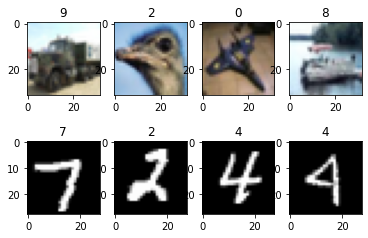

In [2]:
import matplotlib.pyplot as plt
import mindspore.dataset as ds
%matplotlib inline

DATA_DIR_MNIST = "./mnist/"
DATA_DIR_CIFAR10 = "./datasets/cifar-10-batches-bin/"

ds.config.set_seed(1)

# 加载数据集，选取4张图片
dataset_cifar10 = ds.Cifar10Dataset(DATA_DIR_CIFAR10, num_samples=4)
dataset_mnist = ds.MnistDataset(DATA_DIR_MNIST, num_samples=4)

def printDataset(dataset_list, name_list):
    """显示数据集"""
    dataset_sizes = []
    for dataset in dataset_list:
        dataset_sizes.append(dataset.get_dataset_size())
    row = len(dataset_list)      # 画布行数
    column = max(dataset_sizes)  # 画布列数
    pos = 1
    for i in range(row):
        for data in dataset_list[i].create_dict_iterator(output_numpy=True):
            plt.subplot(row, column, pos)                          # 显示位置
            plt.imshow(data['image'].squeeze(), cmap=plt.cm.gray)  # 显示内容
            plt.title(data['label'])                               # 显示标题
            print(name_list[i], " shape:", data['image'].shape, "label:", data['label'])
            pos = pos + 1
        pos = column * (i + 1) + 1

printDataset([dataset_cifar10, dataset_mnist], ["CIFAR-10", "MNIST"])

## mindspore.dataset.vision模块

`vision`模块支持一系列图像数据增强操作。其中部分操作基于C++版OpenCV实现以获得更好的性能；另一些操作则基于Python的PIL库开发。

为了显式使用OpenCV版实现，请使用`Decode(to_pil=False)`操作对图像进行解码，则后续操作都将选择OpenCV版实现（如果存在）。为了在数据处理管道中显式切换到PIL版实现，请先使用`ToPIL()`转换，再进行后续的操作。

为了显式使用PIL版实现，请使用`Decode(to_pil=True)`操作对图像进行解码，则后续操作将选择PIL版实现（如果存在）。为了在数据处理管道中显式切换到OpenCV版实现，请先使用`ToNumpy()`转换，再进行后续的操作。

以下章节使用部分图像增强操作作为简单的示例。

### RandomCrop

`RandomCrop`操作对输入图像进行在随机位置的裁剪。

参数说明：

- `size`：裁剪图像的尺寸。

- `padding`：填充的像素数量。

- `pad_if_needed`：原图小于裁剪尺寸时，是否需要填充。

- `fill_value`：在常量填充模式时使用的填充值。

- `padding_mode`：填充模式。

下面的样例首先使用顺序采样器加载CIFAR-10数据集，然后对已加载的图片进行长宽均为10的随机裁剪，最后输出裁剪前后的图片形状及对应标签，并对图片进行了展示。

Source image  shape: (32, 32, 3) label: 6
Source image  shape: (32, 32, 3) label: 9
Source image  shape: (32, 32, 3) label: 9
Cropped image  shape: (10, 10, 3) label: 6
Cropped image  shape: (10, 10, 3) label: 9
Cropped image  shape: (10, 10, 3) label: 9


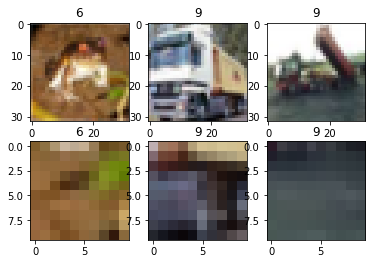

In [3]:
import matplotlib.pyplot as plt
import mindspore.dataset as ds
import mindspore.dataset.vision as vision

ds.config.set_seed(1)

# CIFAR-10数据集加载路径
DATA_DIR = "./datasets/cifar-10-batches-bin/"

# 使用SequentialSampler采样器选取3张图片
sampler = ds.SequentialSampler(num_samples=3)
dataset1 = ds.Cifar10Dataset(DATA_DIR, sampler=sampler)

# 使用RandomCrop对原图进行10*10随机裁剪操作
random_crop = vision.RandomCrop([10, 10])
dataset2 = dataset1.map(operations=random_crop, input_columns=["image"])

printDataset([dataset1, dataset2], ["Source image", "Cropped image"])

从上面的打印和图片显示结果可以看出，图片随机裁剪前后，标签不变，形状发生了变化。裁剪前的图片分辨率为32×32，裁剪后为10×10。

### RandomHorizontalFlip

`RandomHorizontalFlip`操作对输入图像进行随机水平翻转。

参数说明：

- `prob`: 单张图片发生翻转的概率。

下面的样例首先使用随机采样器加载CIFAR-10数据集，然后对已加载的图片进行概率为0.8的随机水平翻转，最后输出翻转前后的图片形状及对应标签，并对图片进行了展示。

Source image  shape: (32, 32, 3) label: 7
Source image  shape: (32, 32, 3) label: 8
Source image  shape: (32, 32, 3) label: 2
Source image  shape: (32, 32, 3) label: 9
Flipped image  shape: (32, 32, 3) label: 7
Flipped image  shape: (32, 32, 3) label: 8
Flipped image  shape: (32, 32, 3) label: 2
Flipped image  shape: (32, 32, 3) label: 9


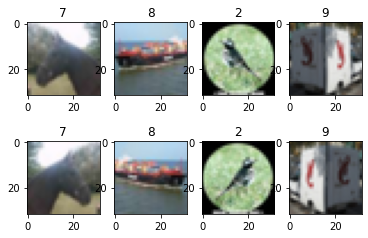

In [4]:
import matplotlib.pyplot as plt
import mindspore.dataset as ds
import mindspore.dataset.vision as vision

ds.config.set_seed(1)

# CIFAR-10数据集加载路径
DATA_DIR = "./datasets/cifar-10-batches-bin/"

# 使用RandomSampler采样器随机选取4张图片
sampler = ds.RandomSampler(num_samples=4)
dataset1 = ds.Cifar10Dataset(DATA_DIR, sampler=sampler)

# 使用RandomHorizontalFlip对原图进行随机水平翻转
random_horizontal_flip = vision.RandomHorizontalFlip(prob=0.8)
dataset2 = dataset1.map(operations=random_horizontal_flip, input_columns=["image"])

printDataset([dataset1, dataset2], ["Source image", "Flipped image"])

从上面的打印和图片显示结果可以看出，经过随机水平翻转操作后，图像的形状、标签均未发生变化，部分图片被水平翻转。

### Resize

`Resize`操作对输入图像进行缩放。

参数说明：

- `size`：缩放的目标大小。
- `interpolation`：缩放时采用的插值方式。

下面的样例首先加载[MNIST数据集[2]](#参考文献)，然后将已加载的图片缩放至(101, 101)大小，最后输出缩放前后的图片形状及对应标签，并对图片进行了展示。

Source image  shape: (28, 28, 1) label: 5
Source image  shape: (28, 28, 1) label: 0
Source image  shape: (28, 28, 1) label: 4
Source image  shape: (28, 28, 1) label: 1
Resized image  shape: (101, 101, 1) label: 5
Resized image  shape: (101, 101, 1) label: 0
Resized image  shape: (101, 101, 1) label: 4
Resized image  shape: (101, 101, 1) label: 1


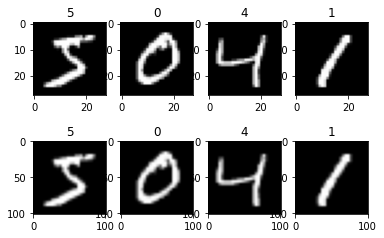

In [5]:
import matplotlib.pyplot as plt
import mindspore.dataset as ds
import mindspore.dataset.vision as vision

# MNIST数据集加载路径
DATA_DIR = "./mnist/"

# 加载MNIST数据集，选取4张图片
dataset1 = ds.MnistDataset(DATA_DIR, num_samples=4, shuffle=False)

# 使用Resize操作对图像进行101×101缩放
resize = vision.Resize(size=[101, 101])
dataset2 = dataset1.map(operations=resize, input_columns=["image"])

printDataset([dataset1, dataset2], ["Source image", "Resized image"])

从上面的打印和图片显示结果可以看出，缩放前后，图片的形状发生了变化，标签未变。缩放前图片分辨率为28×28，缩放后，图片分辨率为101×101。

### Invert

`Invert`操作对输入图像进行反相处理。

下面的样例首先加载CIFAR-10数据集，然后定义反相操作并作用于已加载的图片，最后输出反相前后的图片形状和标签，并对图片进行展示。

Source image  shape: (32, 32, 3) label: 8
Source image  shape: (32, 32, 3) label: 1
Source image  shape: (32, 32, 3) label: 9
Source image  shape: (32, 32, 3) label: 7
Inverted image  shape: (32, 32, 3) label: 8
Inverted image  shape: (32, 32, 3) label: 1
Inverted image  shape: (32, 32, 3) label: 9
Inverted image  shape: (32, 32, 3) label: 7


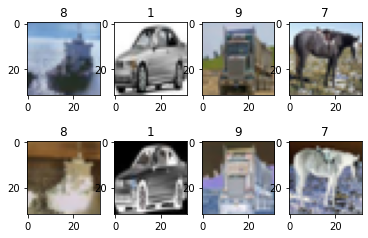

In [6]:
import matplotlib.pyplot as plt
import mindspore.dataset as ds
import mindspore.dataset.vision as vision

ds.config.set_seed(18)

# CIFAR-10数据集加载路径
DATA_DIR = "./datasets/cifar-10-batches-bin/"

# 加载CIFAR-10数据集，选取4张图片
dataset1 = ds.Cifar10Dataset(DATA_DIR, num_samples=4, shuffle=True)

# 对图片进行反相操作
invert = vision.Invert()
dataset2 = dataset1.map(operations=invert, input_columns=["image"])

printDataset([dataset1, dataset2], ["Source image", "Inverted image"])

从上面的打印和图片显示结果可以看出，反相操作前后，图片的形状和标签未变，颜色发生了变化。

## 已废弃`c_transforms`和`py_transforms`模块

从MindSpore 1.8版本开始，以下图像数据增强模块将被废弃：

- mindspore.dataset.vision.c_transforms

- mindspore.dataset.vision.py_transforms

用户应使用以下统一后的模块，其下接口的底层实现可能同时包含C++版OpenCV和Python版PIL，或只有其中之一：

- [mindspore.dataset.vision](https://www.mindspore.cn/docs/zh-CN/master/api_python/mindspore.dataset.vision.html)

### 注意事项

当从已废弃的`c_transforms`或`py_transforms`模块迁移代码至统一后的模块时，其使用方法和原来的`c_transforms`或`py_transforms`模块完全相同，无需更改接口名或入参。

但下列情况除外：

从`mindspore.dataset.vision.py_transforms`迁移至`mindspore.dataset.vision`：

- 原本的`Decode()`接口新增入参`to_pil=True`为`Decode(to_pil=True)`

- 原本的`Cutout(...)`接口统一接口名并新增入参`is_hwc=False`为`CutOut(..., is_hwc=False)`

- 原本的`Normalize(...)`接口新增入参`is_hwc=False`为`Normalize(..., is_hwc=False)`

- 原本的`NormalizePad(...)`接口新增入参`is_hwc=False`为`NormalizePad(..., is_hwc=False)`

从`mindspore.dataset.vision.py_transforms`或`mindspore.dataset.vision.c_transforms`迁移至`mindspore.dataset.vision`：

- 原本的`RgbToBgr`接口统一接口名为`ConvertColor`

从`mindspore.dataset.vision.py_transforms`：

- 原本的`ToType`接口统一接口名为`TypeCast`并移至`mindspore.dataset.transforms`

> 需要注意的是，当接口运行抛错时，已废弃接口的错误信息可能与统一后接口的错误信息不同。

## 参考文献

[1] Alex Krizhevsky. [Learning_Multiple Layers of Features from Tiny Images](http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf).

[2] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. [Gradient-based learning applied to document recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf).

> 本章节中的示例代码依赖第三方支持包`matplotlib`，可使用命令`pip install matplotlib`安装。如本文档以Notebook运行时，完成安装后需要重启kernel才能执行后续代码。